# Imports and Read Data
### 读取原始数据application_train/test.csv，处理完之后保存为processed_train_test.csv。

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# modeling 
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# memory management
import gc

FILE_NAME = "vis.ipynb"
PARENT_DIR = os.path.abspath(os.path.join(os.path.dirname(FILE_NAME), "."))

app_train = pd.read_csv( PARENT_DIR + '/data/application_train.csv')
app_test = pd.read_csv( PARENT_DIR + '/data/application_test.csv')

In [2]:
app_train.shape

(307511, 122)

# Generate New Features
## Polynomial Features
### 提取兴趣特征

In [3]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

### 简单的缺失值处理

In [4]:
# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

### 直接构造多项式特征

In [5]:
from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)

### 新特征可视化

In [8]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET']

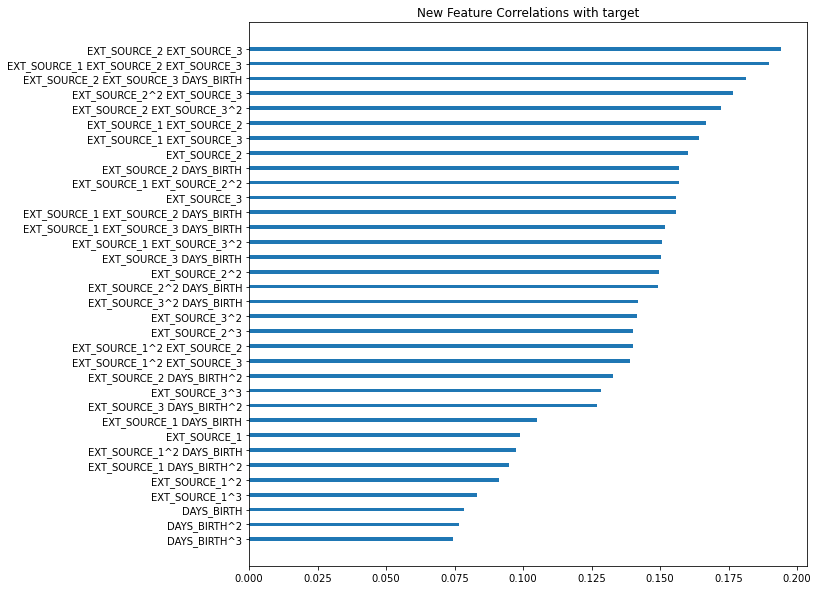

In [9]:
p_corrs = poly_corrs.drop(['TARGET']).drop(['1']).abs().sort_values()

In [ ]:
# Display
plt.figure(figsize = (10, 10))
plt.bar( x=0, bottom=p_corrs.index.astype(str), height=0.25, width=p_corrs.values, orientation="horizontal")
plt.title('New Feature Correlations with target');

In [ ]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['EXT_SOURCE_2 EXT_SOURCE_3', 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3', 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH', 'EXT_SOURCE_2 DAYS_BIRTH']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(poly_features.loc[poly_features['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(poly_features.loc[poly_features['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

### Merge到原数据集中

In [10]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Select the best ones
best_poly_feature_names = p_corrs.tail(10).index.to_list()
best_poly_features = poly_features[best_poly_feature_names]
best_poly_features_test = poly_features_test[best_poly_feature_names]

In [11]:
# Merge polynomial features into training dataframe
best_poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(best_poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
best_poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(best_poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Add the target column to train dataset
app_train_poly['TARGET'] = poly_target

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 132)
Testing data with polynomial features shape:   (48744, 131)


## Domain Knowledge Features
### 训练集构造特征

In [13]:
app_train_domain = app_train_poly.copy()
app_test_domain = app_test_poly.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_CREDIT_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

### 测试集构造特征

In [14]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_CREDIT_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

In [15]:
# Print out the new shapes
print('Training data with polynomial & domain features shape: ', app_train_domain.shape)
print('Testing data with polynomial $ domain features shape:  ', app_test_domain.shape)

Training data with polynomial & domain features shape:  (307511, 136)
Testing data with polynomial $ domain features shape:   (48744, 135)


### 特征相关性可视化

In [ ]:
domain_features = app_train_domain[['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'ANNUITY_CREDIT_PERCENT', 'DAYS_EMPLOYED_PERCENT', 'TARGET']]
domain_corrs = domain_features.corr()['TARGET'].sort_values()
domain_corrs

In [ ]:
# Display most relevant
d_corrs = domain_corrs.drop(['TARGET']).abs().sort_values()

plt.figure(figsize = (10, 5))
plt.bar( x=0, bottom=d_corrs.index.astype(str), height=0.5, width=d_corrs.values, orientation="horizontal")
plt.title('New Feature Correlations with target');

In [ ]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'ANNUITY_CREDIT_PERCENT', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

## Feature Tools

In [ ]:
app_train_auto = app_train.copy()
app_test_auto = app_test.copy()

app_train_auto = app_train_auto.sort_values('SK_ID_CURR').reset_index(drop = True).loc[:1000, :]

In [ ]:
import featuretools as ft

# Entity set with id applications
es = ft.EntitySet(id = 'clients')

# Entities with a unique index
es = es.entity_from_dataframe(entity_id = 'app_train', dataframe = app_train_auto, index = 'SK_ID_CURR')

### Default primitives

In [ ]:
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'transform']

In [ ]:
# Default primitives from featuretools
default_agg_primitives = []
default_trans_primitives =  ["diff", "divide_by_feature", "absolute", "haversine"]

# DFS with specified primitives
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'app_train',
                    trans_primitives = default_trans_primitives,
                    agg_primitives = default_agg_primitives,
                    max_depth = 2, features_only = False, verbose = True)

print('%d Total Features' % len(feature_names))

In [ ]:
feature_matrix.shape

In [ ]:
feature_names[-20:]

## Result datasets with new features

In [19]:
app_train_nf = app_train_domain.copy()
app_test_nf = app_test_domain.copy()

# Feature Selection
## Remove Collinear Variables

In [20]:
# Absolute value correlation matrix
corr_matrix = app_train_nf.corr().abs()
corr_matrix.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_2 EXT_SOURCE_3,TARGET,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,ANNUITY_CREDIT_PERCENT,DAYS_EMPLOYED_PERCENT
SK_ID_CURR,1.000000,0.001129,0.001820,0.000343,0.000433,0.000232,0.000849,0.001500,0.001366,0.000973,...,0.001338,0.001527,0.001149,0.001189,0.001658,0.002108,0.001726,0.002351,0.000319,0.001584
CNT_CHILDREN,0.001129,1.000000,0.012882,0.002145,0.021374,0.001827,0.025573,0.330938,0.239818,0.183395,...,0.039596,0.035572,0.175433,0.073692,0.037726,0.019187,0.016012,0.002296,0.020751,0.231710
AMT_INCOME_TOTAL,0.001820,0.012882,1.000000,0.156870,0.191657,0.159610,0.074796,0.027261,0.064223,0.027805,...,0.008854,0.039285,0.006438,0.031090,0.023917,0.003982,0.108191,0.153033,0.026788,0.061637
AMT_CREDIT,0.000343,0.002145,0.156870,1.000000,0.770138,0.986968,0.099738,0.055436,0.066838,0.009621,...,0.090770,0.127608,0.107749,0.141562,0.113471,0.030369,0.651097,0.373921,0.558789,0.059482
AMT_ANNUITY,0.000433,0.021374,0.191657,0.770138,1.000000,0.775109,0.118429,0.009445,0.104332,0.038514,...,0.083815,0.120899,0.078002,0.123227,0.105109,0.012817,0.393239,0.484624,0.063489,0.098235


In [25]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_2 EXT_SOURCE_3,TARGET,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,ANNUITY_CREDIT_PERCENT,DAYS_EMPLOYED_PERCENT
SK_ID_CURR,NaN,0.001129,0.001820,0.000343,0.000433,0.000232,0.000849,0.001500,0.001366,0.000973,...,0.001338,0.001527,0.001149,0.001189,0.001658,0.002108,0.001726,0.002351,0.000319,0.001584
CNT_CHILDREN,NaN,NaN,0.012882,0.002145,0.021374,0.001827,0.025573,0.330938,0.239818,0.183395,...,0.039596,0.035572,0.175433,0.073692,0.037726,0.019187,0.016012,0.002296,0.020751,0.231710
AMT_INCOME_TOTAL,NaN,NaN,NaN,0.156870,0.191657,0.159610,0.074796,0.027261,0.064223,0.027805,...,0.008854,0.039285,0.006438,0.031090,0.023917,0.003982,0.108191,0.153033,0.026788,0.061637
AMT_CREDIT,NaN,NaN,NaN,NaN,0.770138,0.986968,0.099738,0.055436,0.066838,0.009621,...,0.090770,0.127608,0.107749,0.141562,0.113471,0.030369,0.651097,0.373921,0.558789,0.059482
AMT_ANNUITY,NaN,NaN,NaN,NaN,NaN,0.775109,0.118429,0.009445,0.104332,0.038514,...,0.083815,0.120899,0.078002,0.123227,0.105109,0.012817,0.393239,0.484624,0.063489,0.098235


In [44]:
# Threshold for removing correlated variables
threshold = 0.975

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 22 columns to remove.


In [43]:
app_train_nf = app_train_nf.drop(columns = to_drop)
app_test_nf = app_test_nf.drop(columns = to_drop)

print('Training shape: ', app_train_nf.shape)
print('Testing shape: ', app_test_nf.shape)

Training shape:  (307511, 111)
Testing shape:  (48744, 110)


## Remove missing values

In [46]:
# Train missing values (in percent)
train_missing = (app_train_nf.isnull().sum() / len(app_train_nf)).sort_values(ascending = False)
train_missing.head(10)

COMMONAREA_AVG              0.698723
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_AVG        0.683550
LIVINGAPARTMENTS_MODE       0.683550
FLOORSMIN_AVG               0.678486
YEARS_BUILD_AVG             0.664978
OWN_CAR_AGE                 0.659908
LANDAREA_AVG                0.593767
dtype: float64

In [48]:
# Test missing values (in percent)
test_missing = (app_test_nf.isnull().sum() / len(app_test_nf)).sort_values(ascending = False)
test_missing.head(10)

COMMONAREA_AVG              0.687161
NONLIVINGAPARTMENTS_MODE    0.684125
NONLIVINGAPARTMENTS_AVG     0.684125
FONDKAPREMONT_MODE          0.672842
LIVINGAPARTMENTS_MODE       0.672493
LIVINGAPARTMENTS_AVG        0.672493
FLOORSMIN_AVG               0.666051
OWN_CAR_AGE                 0.662892
YEARS_BUILD_AVG             0.652757
LANDAREA_AVG                0.579641
dtype: float64

In [49]:
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

There are 0 columns with more than 75% missing values


In [ ]:
app_train_nf = pd.get_dummies(app_train_nf.drop(columns = all_missing))
app_test_nf = pd.get_dummies(app_test_nf.drop(columns = all_missing))

## Remove features with lower importance

In [56]:
# some pre
# Need to save the labels because aligning will remove this column
train_labels = app_train_nf["TARGET"]
train_ids = app_train_nf['SK_ID_CURR']
test_ids = app_test_nf['SK_ID_CURR']

app_train_nf = pd.get_dummies(app_train_nf.drop(columns = all_missing))
app_test_nf = pd.get_dummies(app_test_nf.drop(columns = all_missing))

app_train_nf, app_test_nf = app_train_nf.align(app_test_nf, join = 'inner', axis = 1)

print('Training set full shape: ', app_train_nf.shape)
print('Testing set full shape: ' , app_test_nf.shape)

Training set full shape:  (307511, 231)
Testing set full shape:  (48744, 231)


In [57]:
app_train_nf = app_train_nf.drop(columns = ['SK_ID_CURR'])
app_test_nf = app_test_nf.drop(columns = ['SK_ID_CURR'])

In [61]:
imputer2 = SimpleImputer(strategy = 'median')
# Need to impute missing values
app_train_nf = imputer2.fit_transform(app_train_nf)
app_train_nf = pd.DataFrame(app_train_nf)

In [58]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(app_train_nf.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [65]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(app_train_nf, train_labels, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.765014	valid_0's binary_logloss: 0.538019
Early stopping, best iteration is:
[112]	valid_0's auc: 0.765991	valid_0's binary_logloss: 0.555565
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.765155	valid_0's binary_logloss: 0.540075
Early stopping, best iteration is:
[125]	valid_0's auc: 0.766192	valid_0's binary_logloss: 0.554592


In [68]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(app_train_nf.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
92,92,100.125
5,5,41.750
6,6,30.500
25,25,29.000
3,3,28.750


In [69]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 45 features with 0.0 importance


,feature,importance
63,63,0.0
174,174,0.0
138,138,0.0
203,203,0.0
105,105,0.0
